# **07_Traditional_Models**

## Ray Hossain




## Setup

In [1]:
#%pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.stats import linregress

In [3]:
# Load the data
data = pd.read_csv('Processed_Data/51_textscored_wide.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   personid                    1344 non-null   int64  
 1   duration                    1008 non-null   float64
 2   text_clean                  1008 non-null   object 
 3   secondvote                  1344 non-null   int64  
 4   vote_left                   1344 non-null   int64  
 5   vote_green                  1344 non-null   int64  
 6   vote_spd                    1344 non-null   int64  
 7   vote_na_other               1344 non-null   int64  
 8   vote_fdp                    1344 non-null   int64  
 9   vote_cdu                    1344 non-null   int64  
 10  vote_afd                    1344 non-null   int64  
 11  news_proportion             1344 non-null   float64
 12  age                         1344 non-null   int64  
 13  ml_gender_female            1344 

## Exploratory Data Analysis

In [5]:
df = data.drop(['personid', 'text_clean', 'secondvote', 'adjustedvote',
                'vote_left', 'vote_green', 'vote_spd', 'vote_na_other', 'vote_fdp',
                'vote_cdu', 'vote_afd', 'fgender', 'fvoceduc', 'frelationship', 'femployment',
                'fmaritalstatus', 'polinterest'], axis = 1)

One-Hot Encoding of Categorical Variables

In this step, we are applying one-hot encoding to two categorical variables: `polinterest` and `adjustedincome`. One-hot encoding is a process that converts categorical variables into a series of binary (0 or 1) columns. Each category level is represented by a separate column, and the presence of the category is indicated by a 1, while the absence is indicated by a 0. It transforms these variables into a numerical format that can be easily processed by machine learning models and ensures that the model does not mistakenly interpret the categorical variables as ordinal.

In [6]:
df = pd.get_dummies(df, columns=['adjustedincome'], drop_first=False, dtype='int')


In [7]:
#df['ml_gender_male'] = (df['ml_gender_female'] == 0).astype(int)
#df['ml_single'] = (df['ml_relationship'] == 0).astype(int)
#df['ml_not_married'] = (df['ml_married'] == 0).astype(int)
#df['ml_not_employed'] = (df['ml_employ'] == 0).astype(int)
#df['ml_no_degree'] = (df['ml_degreestatus'] == 0).astype(int)
#df['ml_no_polinterest'] = (df['ml_political_interest'] == 0).astype(int)
## I MADE THESE TO CHECK THE VALUES JUST IN CASE THEY ARE IMPORTANT. THEY ARE NOT.

11) We use `df.isna().sum()` to identify and count the number of missing values (NaNs) in each column.

In [8]:
# Identify non-finite values
print(df.isna().sum())

# Fill NaN values with 0
df.fillna(0, inplace=True)

duration                      336
news_proportion                 0
age                             0
ml_gender_female                0
ml_married                      0
ml_relationship                 0
ml_employ                       0
ml_degreestatus                 0
ml_political_interest           0
tf_idf_mean                     0
tf_idf_entity_weighted          0
tf_idf_importance_weighted      0
left_right                      0
adjustedincome_1                0
adjustedincome_2                0
adjustedincome_3                0
adjustedincome_4                0
adjustedincome_5                0
adjustedincome_6                0
adjustedincome_7                0
adjustedincome_8                0
adjustedincome_9                0
adjustedincome_10               0
adjustedincome_11               0
adjustedincome_12               0
dtype: int64


12) We use `df.info()` to get a summary of the data frame after conversion. The DataFrame contains 43 columns and 47145 entries (rows). There are no missing values, indicating that all non-finite values (such as NaN or inf) have been handled or replaced with 0.

In [9]:
# Convert DataFrame to integers
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   duration                    1344 non-null   int32
 1   news_proportion             1344 non-null   int32
 2   age                         1344 non-null   int32
 3   ml_gender_female            1344 non-null   int32
 4   ml_married                  1344 non-null   int32
 5   ml_relationship             1344 non-null   int32
 6   ml_employ                   1344 non-null   int32
 7   ml_degreestatus             1344 non-null   int32
 8   ml_political_interest       1344 non-null   int32
 9   tf_idf_mean                 1344 non-null   int32
 10  tf_idf_entity_weighted      1344 non-null   int32
 11  tf_idf_importance_weighted  1344 non-null   int32
 12  left_right                  1344 non-null   int32
 13  adjustedincome_1            1344 non-null   int32
 14  adjusted

13) The output displays the unique values along with their respective counts for each column, which helps in understanding the distribution and variability of values within each feature。

**WE CHANGED ALL VALUES OF -1 (LEFT WING IDEOLOGY) TO 2 FOR THE MACHINE LEARNING MODEL**

In [10]:
df['left_right'] = df['left_right'].replace(-1, 2)

In [11]:
X = df.drop('left_right', axis = 1)

y = df['left_right']

In [12]:
# Get the counts of unique values for all columns
unique_counts_all_columns = df.apply(lambda x: x.unique())

# Display the result
print(unique_counts_all_columns)

duration                      [111731, 5429, 1317, 1548, 792, 3031, 7254, 32...
news_proportion                                                             [0]
age                           [52, 55, 39, 70, 47, 48, 38, 36, 54, 50, 29, 4...
ml_gender_female                                                         [0, 1]
ml_married                                                               [1, 0]
ml_relationship                                                          [1, 0]
ml_employ                                                                [1, 0]
ml_degreestatus                                                          [1, 0]
ml_political_interest                                                    [1, 0]
tf_idf_mean                                                                 [0]
tf_idf_entity_weighted                                                   [0, 1]
tf_idf_importance_weighted                                               [0, 1]
left_right                              

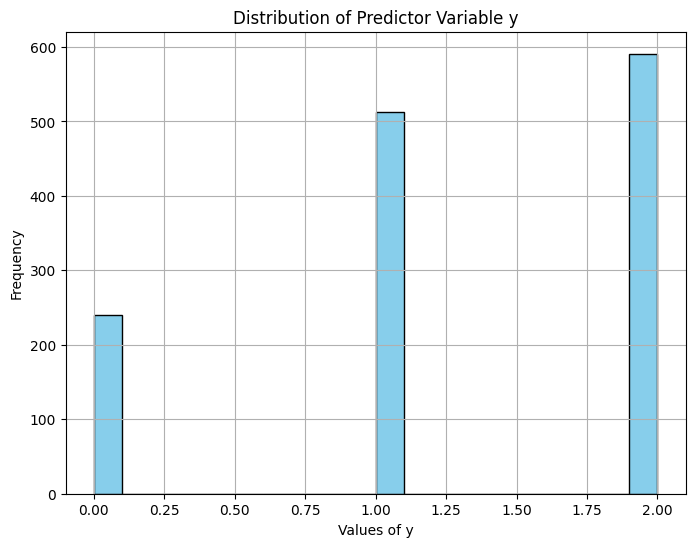

In [13]:
# Plot a histogram of the predictor variable y
plt.figure(figsize=(8, 6))
plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values of y')
plt.ylabel('Frequency')
plt.title('Distribution of Predictor Variable y')
plt.grid(True)
plt.show()

### Train-test split

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

The test set, comprising 30% of our data, was selected randomly to represent the overall distribution of the data and to prevent model overfitting on the training set. This split ensures that the model's performance is tested on unseen data, providing a fair assessment of its generalization ability.

### Feature Selection


In the first pass, the following features were the highest: `adjustedincome_` (3,4,6,7,8,9), `ml_political_interest` and `polinterest_1` (we will only keep ml_political_interest because its binary) . The top feature might reflect user-specific interpretations that could be biased.

In the second pass, after removing `tf_idf_importance` and `polinterest`, a lot more features are relevant. Based on the graph, we will not be using anything below `adjustedincome_5`


c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:59:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


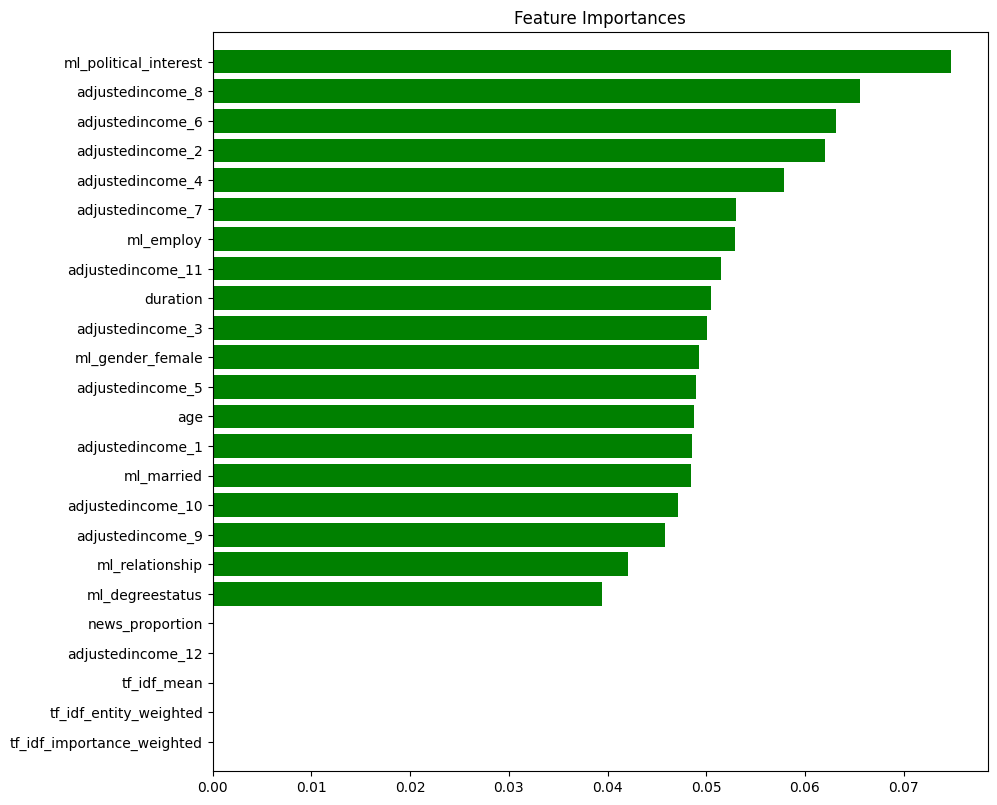

In [15]:
# Initialize and train the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Get feature importances and sort them in ascending order for better visualization
importances = xgb.feature_importances_
indices = np.argsort(importances)

# Calculate the appropriate figure height: consider each bar's height and spacing
# Suppose you want at least 0.4 units per bar for clarity
fig_height = len(indices) * 0.4  # Adjust 0.4 to more or less depending on your preference

plt.figure(figsize=(10, fig_height))  # Width is fixed, height is dynamically adjusted
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.ylim([-1, len(indices)])
plt.show()

We will drop anything below a 0.05

In [16]:

df = df.drop(['news_proportion', 'adjustedincome_12',
                   'ml_degreestatus', 'ml_relationship', 'adjustedincome_9',
                   'adjustedincome_10', 'tf_idf_entity_weighted', 'tf_idf_importance_weighted', 'tf_idf_mean'
                   ], axis= 1)




In [17]:
X = df.drop('left_right', axis = 1)

y = df['left_right']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:59:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


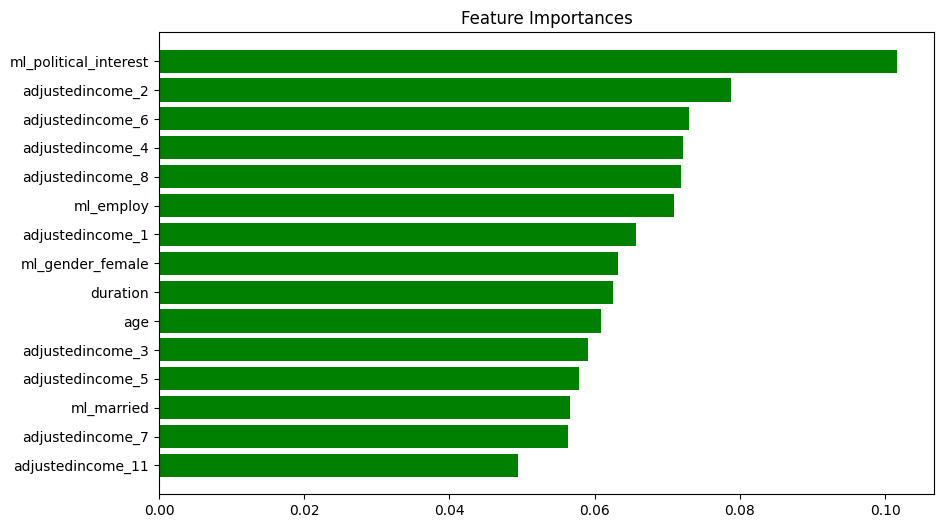

In [18]:
# Initialize and train the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Get feature importances and sort them in ascending order for better visualization
importances = xgb.feature_importances_
indices = np.argsort(importances)

# Calculate the appropriate figure height: consider each bar's height and spacing
# Suppose you want at least 0.4 units per bar for clarity
fig_height = len(indices) * 0.4  # Adjust 0.4 to more or less depending on your preference

plt.figure(figsize=(10, fig_height))  # Width is fixed, height is dynamically adjusted
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.ylim([-1, len(indices)])
plt.show()

In [19]:
# Get feature names
feature_names = X_train.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': importances
})

# Sort the feature importance DataFrame by XGBoost importance scores
feature_importance_df_sorted_xgb = feature_importance_df.sort_values(by='XGBoost', ascending=False)

# Select the top 12 rows
top_12_xgb = feature_importance_df_sorted_xgb.head(15)

# Display the top 12 values for XGBoost
print("Top 12 Feature Importance Comparison - XGBoost:")
print(top_12_xgb)

# Extract the top 12 features as a list
xgboost_importance_list = top_12_xgb['Feature'].tolist()
print("XGBoost Importance List:", xgboost_importance_list)



Top 12 Feature Importance Comparison - XGBoost:
                  Feature   XGBoost
5   ml_political_interest  0.101656
7        adjustedincome_2  0.078790
11       adjustedincome_6  0.073067
9        adjustedincome_4  0.072121
13       adjustedincome_8  0.071927
4               ml_employ  0.070904
6        adjustedincome_1  0.065719
2        ml_gender_female  0.063279
0                duration  0.062478
1                     age  0.060853
8        adjustedincome_3  0.059095
10       adjustedincome_5  0.057788
3              ml_married  0.056581
12       adjustedincome_7  0.056361
14      adjustedincome_11  0.049380
XGBoost Importance List: ['ml_political_interest', 'adjustedincome_2', 'adjustedincome_6', 'adjustedincome_4', 'adjustedincome_8', 'ml_employ', 'adjustedincome_1', 'ml_gender_female', 'duration', 'age', 'adjustedincome_3', 'adjustedincome_5', 'ml_married', 'adjustedincome_7', 'adjustedincome_11']


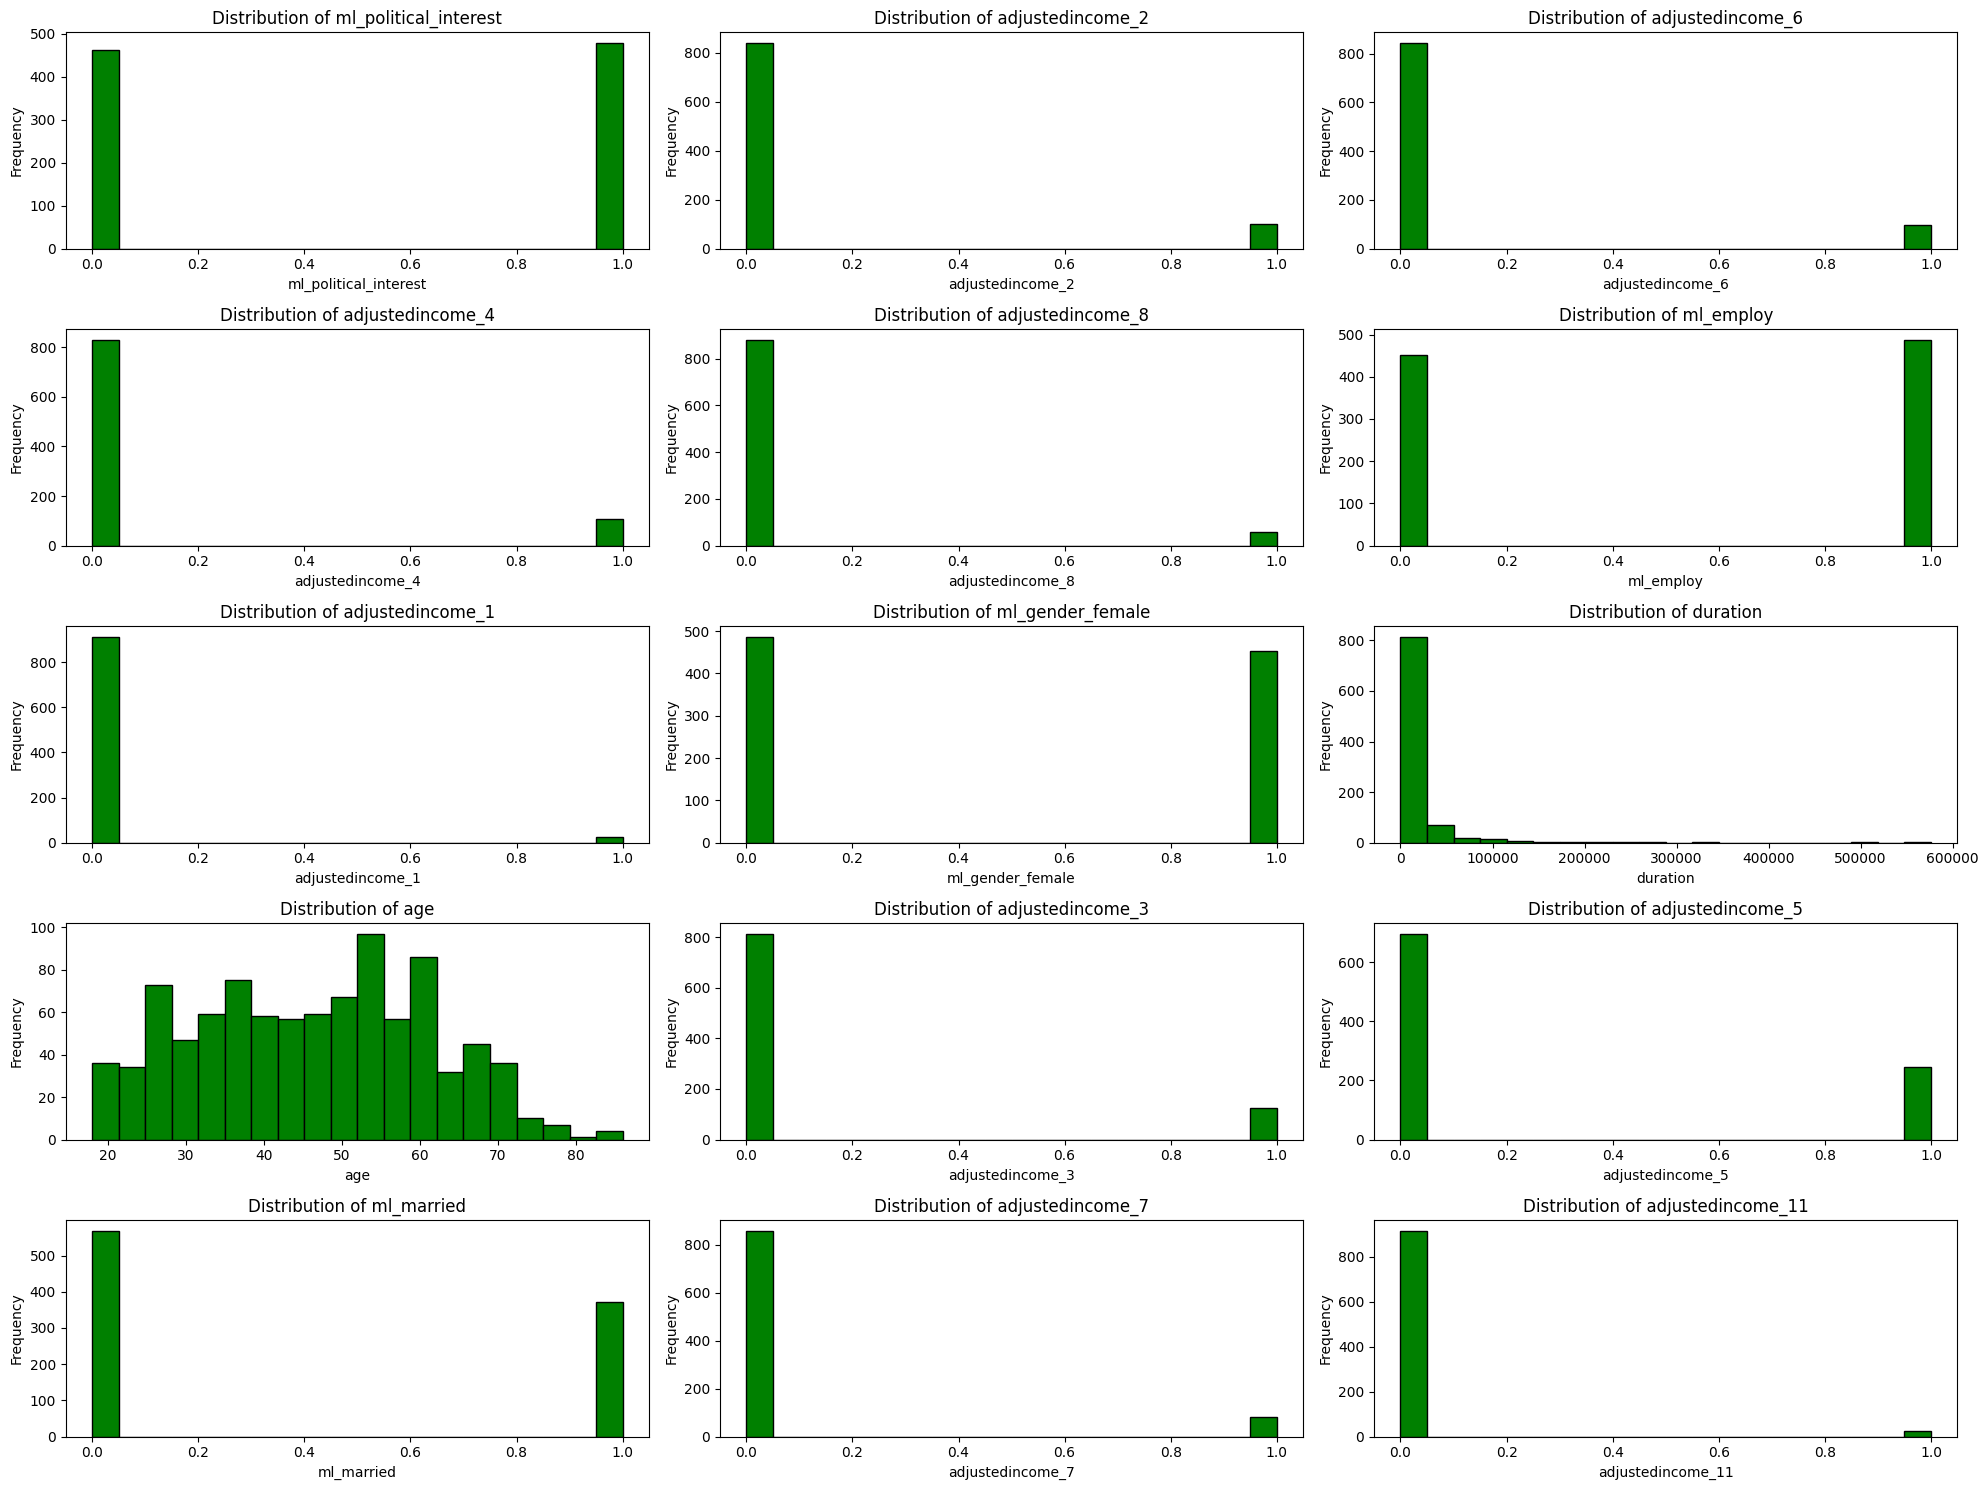

In [20]:
# Plot histograms for the top 12 features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(xgboost_importance_list, 1):
    plt.subplot(5, 3, i)
    plt.hist(X_train[feature], bins=20, color='green', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

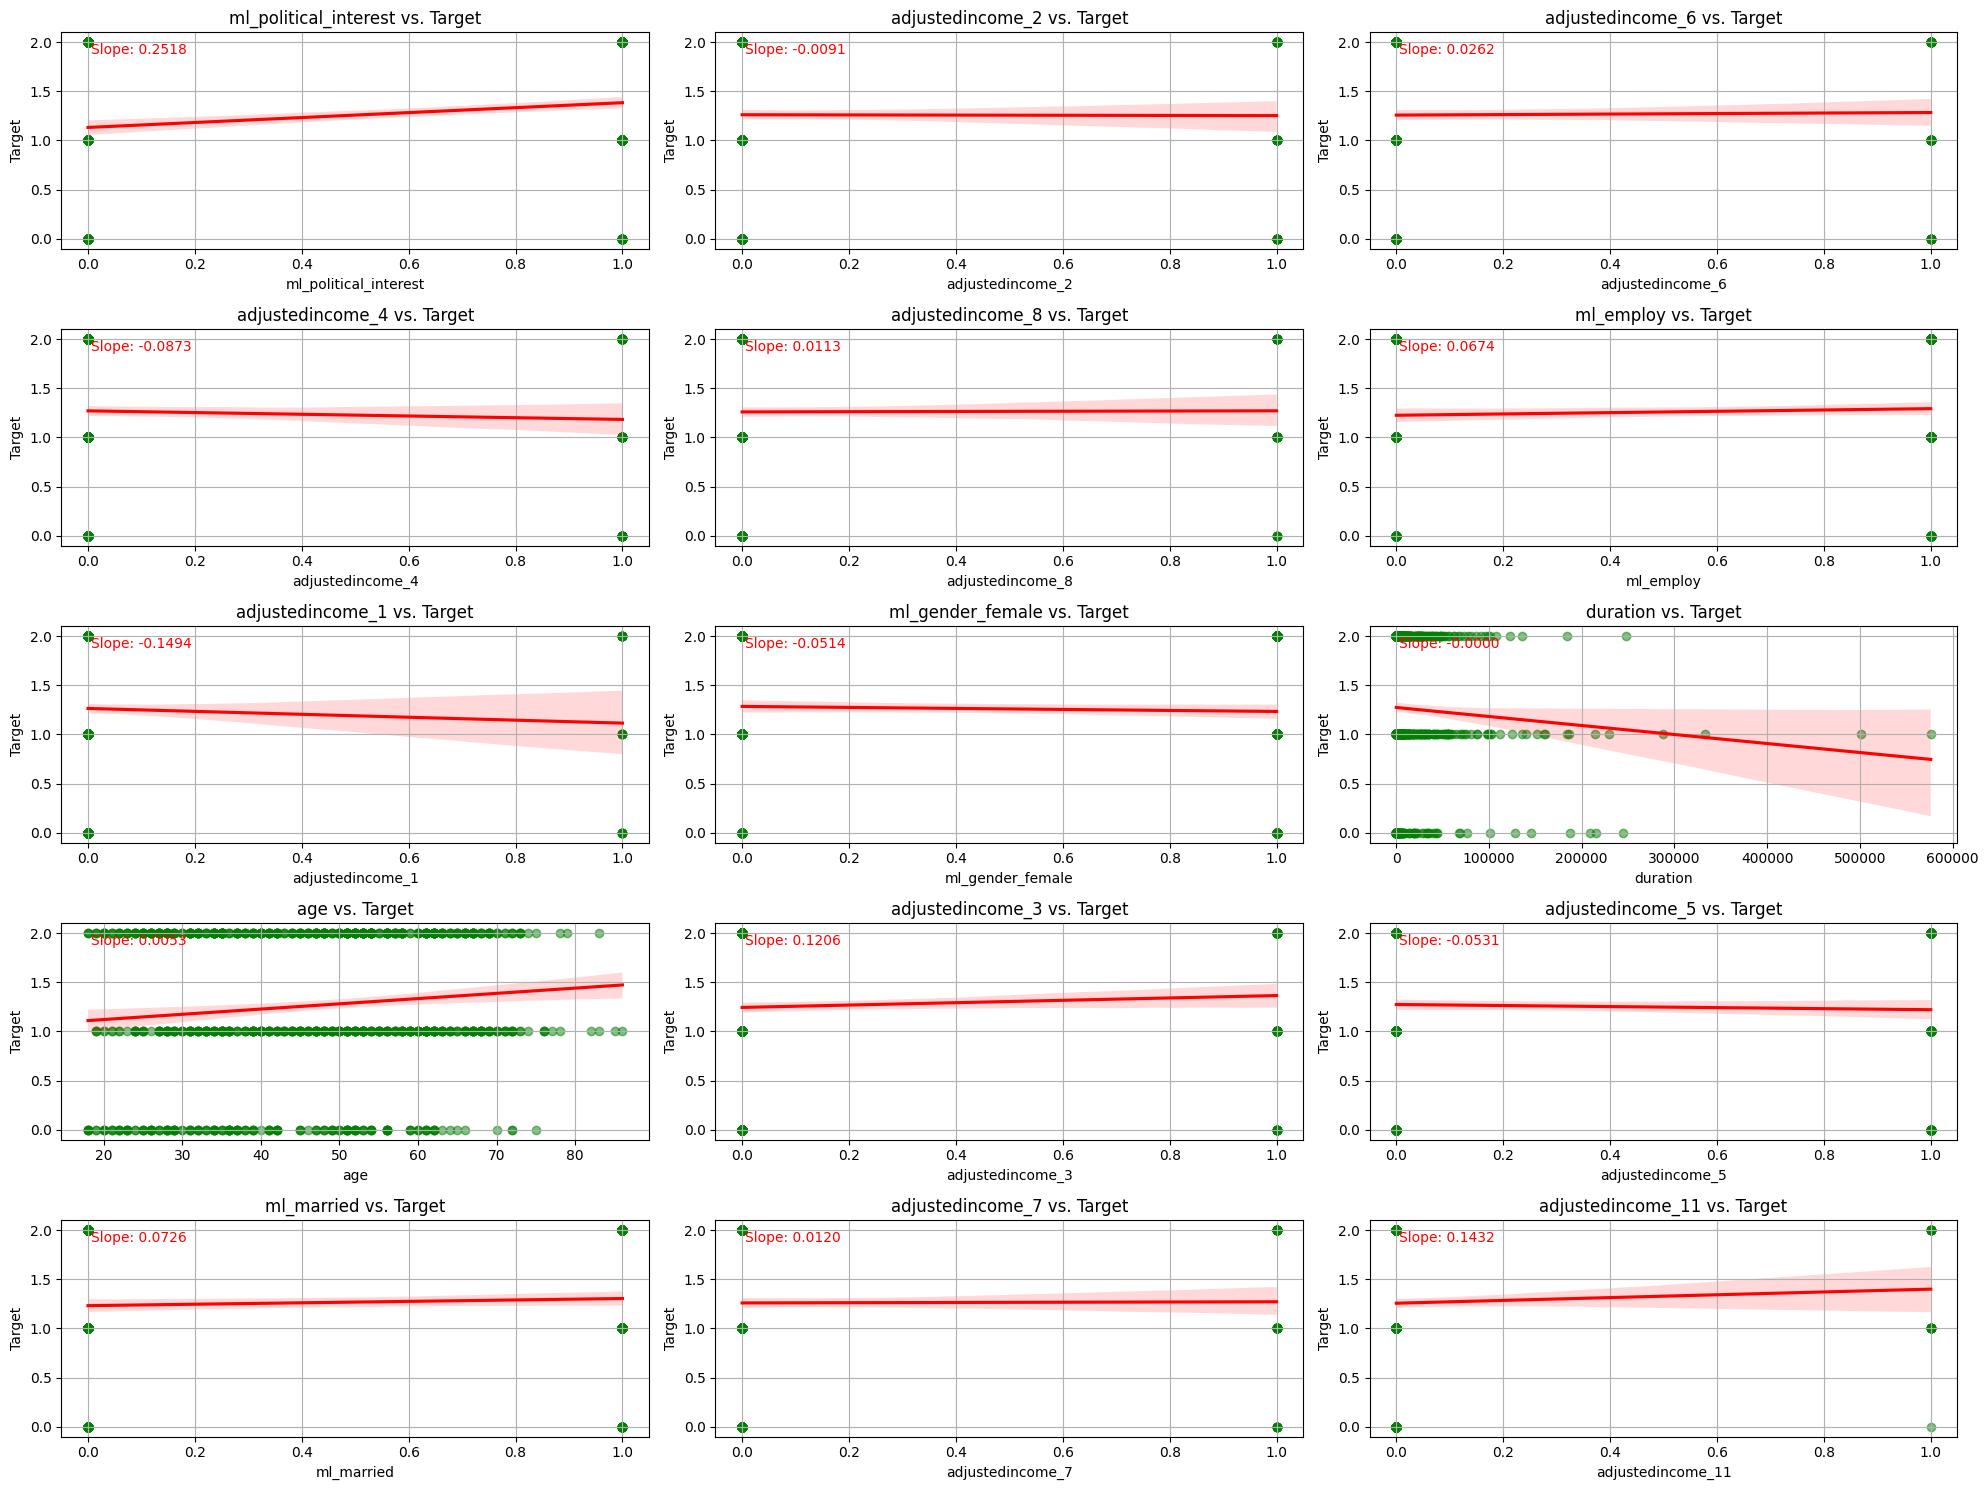

Coefficients of the Regression Lines:
                  Feature   Coefficient
0   ml_political_interest  2.518126e-01
1        adjustedincome_2 -9.068089e-03
2        adjustedincome_6  2.622236e-02
3        adjustedincome_4 -8.727188e-02
4        adjustedincome_8  1.125455e-02
5               ml_employ  6.736907e-02
6        adjustedincome_1 -1.493856e-01
7        ml_gender_female -5.142536e-02
8                duration -9.160294e-07
9                     age  5.328896e-03
10       adjustedincome_3  1.206076e-01
11       adjustedincome_5 -5.311381e-02
12             ml_married  7.259627e-02
13       adjustedincome_7  1.200075e-02
14      adjustedincome_11  1.431694e-01


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Create scatter plots with regression lines for the top 12 features against the target variable
plt.figure(figsize=(20, 15))
coefficients = []

for i, feature in enumerate(top_12_xgb['Feature'], 1):
    plt.subplot(5, 3, i)
    sns.regplot(x=X_train[feature], y=y_train, scatter_kws={'alpha':0.5, 'color':'green'}, line_kws={'color':'red'})

    # Fit a linear regression model and get the coefficient
    slope, intercept, r_value, p_value, std_err = linregress(X_train[feature], y_train)
    coefficients.append((feature, slope))

    # Annotate the slope on the graph
    plt.annotate(f'Slope: {slope:.4f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red',
                 horizontalalignment='left', verticalalignment='top')

    plt.title(f'{feature} vs. Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Display the coefficients
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
print("Coefficients of the Regression Lines:")
print(coefficients_df)

Notes that are hard to understand have the highest positive coefficient, strongly indicating that notes difficult to comprehend are more frequently flagged as spam. This could reflect users' preferences for clear and straightforward information.

## Model & Evaluation

Comparing feature importances across different models; Random Forest, Logistic Regression (Lasso) and XGBoost.

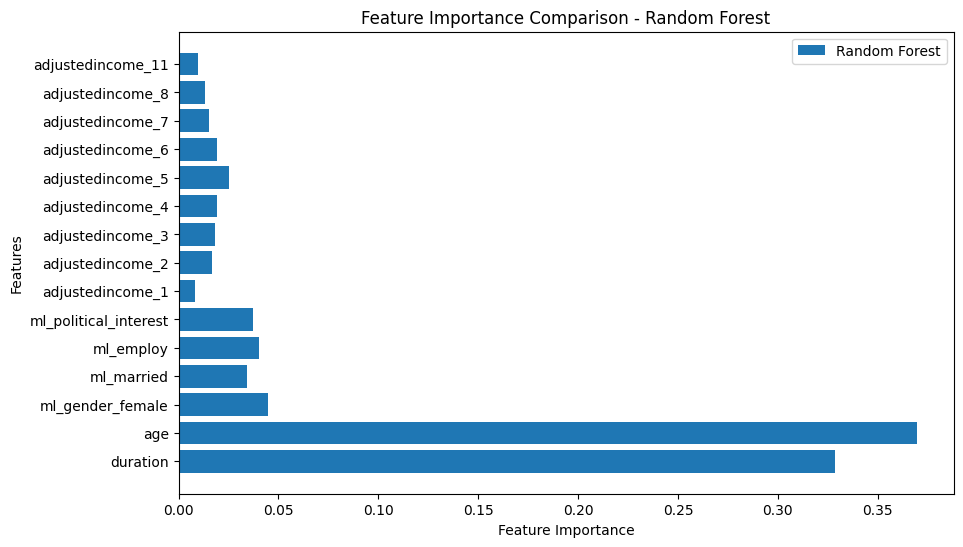

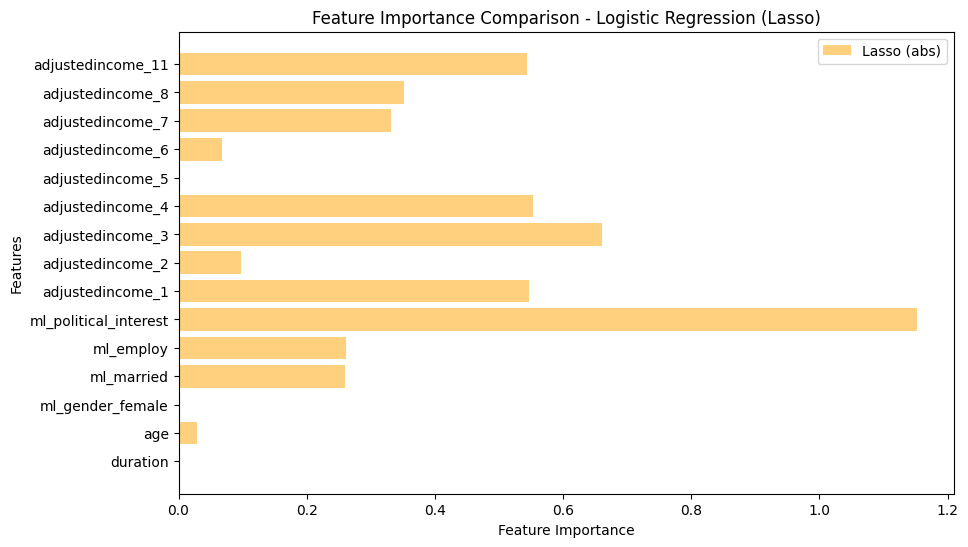

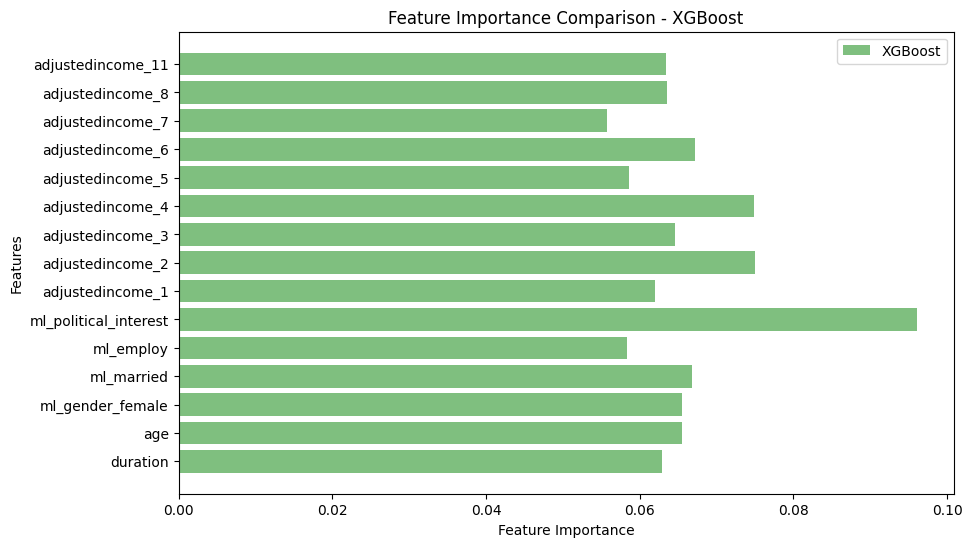

In [22]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imputed, y)

# Train Logistic Regression with L1 regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_imputed, y)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_imputed, y)

# Get feature names
feature_names = X.columns

# Get feature importance from each model
rf_feature_importance = rf.feature_importances_
lasso_feature_importance = lasso.coef_[0]
xgb_feature_importance = xgb.feature_importances_

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_feature_importance, label='Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - Random Forest')
plt.legend()
plt.show()

# Plot feature importance for Logistic Regression (Lasso)
plt.figure(figsize=(10, 6))
plt.barh(feature_names, abs(lasso_feature_importance), alpha=0.5, label='Lasso (abs)', color='orange')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - Logistic Regression (Lasso)')
plt.legend()
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importance, alpha=0.5, label='XGBoost', color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison - XGBoost')
plt.legend()
plt.show()

In [23]:
# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_feature_importance,
    'Lasso (L1 Regularization)': abs(lasso_feature_importance),
    'XGBoost': xgb_feature_importance
})

# Display the feature importance DataFrame
print("Feature Importance Comparison")
print(feature_importance_df)

Feature Importance Comparison
                  Feature  Random Forest  Lasso (L1 Regularization)   XGBoost
0                duration       0.328322               2.249953e-07  0.062902
1                     age       0.369422               2.849015e-02  0.065497
2        ml_gender_female       0.044582               0.000000e+00  0.065488
3              ml_married       0.034098               2.592023e-01  0.066805
4               ml_employ       0.040435               2.611556e-01  0.058293
5   ml_political_interest       0.037350               1.151635e+00  0.096017
6        adjustedincome_1       0.008263               5.468003e-01  0.061993
7        adjustedincome_2       0.016632               9.733283e-02  0.075043
8        adjustedincome_3       0.018423               6.609073e-01  0.064619
9        adjustedincome_4       0.019386               5.538457e-01  0.074858
10       adjustedincome_5       0.025301               0.000000e+00  0.058553
11       adjustedincome_6       0.

### Cross Validation

We employed cross-validation, specifically a K-Fold method with 10 splits, to optimize hyperparameters and assess model stability across different subsets of data. This approach allows us to understand the variance in the model's performance and ensure that our results are not dependent on a particular partition of the data.

Later, we did hyperparameter tuning using GridSearchCV for each model, which systematically works through multiple combinations of parameters, cross-validating as it goes to determine which tune yields the best performance metric, typically focusing on accuracy.

**
Cross-Validation with Median Imputation: In this approach, missing values in the dataset are first replaced with the median of their respective features. Then, the dataset is divided into folds for cross-validation. During each iteration of cross-validation, the model is trained on the training folds containing imputed data and tested on the validation fold, which may contain both imputed and original data.


Also note: I am resusing the code so the imputation methods here are irrelevant

In [24]:
# Create pipelines for each model with mean imputation
models_mean_imputation = {
    "Logistic Regression": make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        LogisticRegression(max_iter=100)
    ),
    "Random Forest": make_pipeline(
        SimpleImputer(strategy='mean'),
        RandomForestClassifier(random_state=42)
    ),
    "Decision Tree": make_pipeline(
        SimpleImputer(strategy='mean'),
        DecisionTreeClassifier(random_state=42)
    ),
    "Support Vector Machine": make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        SVC(kernel='linear')
    ),
    "Gradient Boosting": make_pipeline(
        SimpleImputer(strategy='mean'),
        GradientBoostingClassifier(random_state=42)
    )
}

# Perform cross-validation and store results for mean imputation
results_mean_imputation = {}
for name, model in models_mean_imputation.items():
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    results_mean_imputation[name] = cv_scores

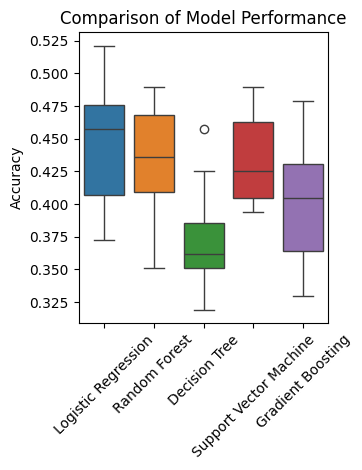

In [25]:
plt.subplot(1, 2, 1)
sns.boxplot(data=pd.DataFrame(results_mean_imputation))
plt.ylabel('Accuracy')
plt.xticks(rotation=45)


plt.title('Comparison of Model Performance')
plt.tight_layout()
plt.show()

Now let's tune the hyperparameters.

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters for Logistic Regression: {'logisticregression__C': 1, 'logisticregression__solver': 'sag'}
Best Hyperparameters for Random Forest: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 200}
Best Hyperparameters for Decision Tree: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 2}
Best Hyperparameters for Support Vector Machine: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best Hyperparameters for Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 100}


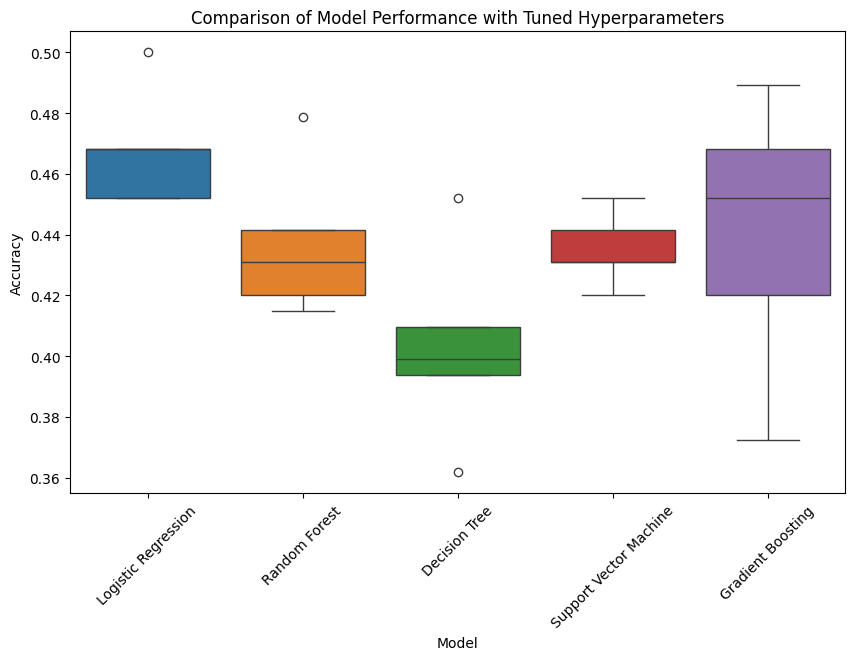

In [26]:
# Define hyperparameters for each model
param_grid_lr = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'sag']
}

param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20]
}

param_grid_dt = {
    'decisiontreeclassifier__max_depth': [None, 10, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

param_grid_gb = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5]
}

# Create grid search objects for each model
grid_search_lr = GridSearchCV(models_mean_imputation['Logistic Regression'], param_grid_lr, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(models_mean_imputation['Random Forest'], param_grid_rf, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(models_mean_imputation['Decision Tree'], param_grid_dt, cv=5, scoring='accuracy')
grid_search_svc = GridSearchCV(models_mean_imputation['Support Vector Machine'], param_grid_svc, cv=5, scoring='accuracy')
grid_search_gb = GridSearchCV(models_mean_imputation['Gradient Boosting'], param_grid_gb, cv=5, scoring='accuracy')

# Perform grid search for each model
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_dt = grid_search_dt.best_params_
best_params_svc = grid_search_svc.best_params_
best_params_gb = grid_search_gb.best_params_

# Print the best hyperparameters for each model
print("Best Hyperparameters for Logistic Regression:", best_params_lr)
print("Best Hyperparameters for Random Forest:", best_params_rf)
print("Best Hyperparameters for Decision Tree:", best_params_dt)
print("Best Hyperparameters for Support Vector Machine:", best_params_svc)
print("Best Hyperparameters for Gradient Boosting:", best_params_gb)

# Use the best models with tuned hyperparameters for evaluation
best_model_lr = grid_search_lr.best_estimator_
best_model_rf = grid_search_rf.best_estimator_
best_model_dt = grid_search_dt.best_estimator_
best_model_svc = grid_search_svc.best_estimator_
best_model_gb = grid_search_gb.best_estimator_

# Perform cross-validation with the best models
cv_scores_lr = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(best_model_rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_dt = cross_val_score(best_model_dt, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_svc = cross_val_score(best_model_svc, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_gb = cross_val_score(best_model_gb, X_train, y_train, cv=5, scoring='accuracy')

# Store the results
results_best_models = {
    "Logistic Regression": cv_scores_lr,
    "Random Forest": cv_scores_rf,
    "Decision Tree": cv_scores_dt,
    "Support Vector Machine": cv_scores_svc,
    "Gradient Boosting": cv_scores_gb
}

# Visualize the performance of different models with mean imputation and tuned hyperparameters
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(results_best_models))
plt.title('Comparison of Model Performance with Tuned Hyperparameters')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Create lists to store the results
model_names = []
hyperparameters_list = []
mean_accuracies = []

# Populate the lists with results
for model_name, cv_scores in results_best_models.items():
    mean_accuracy = cv_scores.mean()
    hyperparameters = ''
    if model_name == "Logistic Regression":
        hyperparameters = best_params_lr
    elif model_name == "Random Forest":
        hyperparameters = best_params_rf
    elif model_name == "Decision Tree":
        hyperparameters = best_params_dt
    elif model_name == "Support Vector Machine":
        hyperparameters = best_params_svc
    elif model_name == "Gradient Boosting":
        hyperparameters = best_params_gb

    model_names.append(model_name)
    hyperparameters_list.append(hyperparameters)
    mean_accuracies.append(mean_accuracy)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Hyperparameters': hyperparameters_list,
    'Mean Accuracy': mean_accuracies
})

# Display the results DataFrame
print("Model Performance and Hyperparameters:\n")
print(results_df)

Model Performance and Hyperparameters:

                    Model                                    Hyperparameters  \
0     Logistic Regression  {'logisticregression__C': 1, 'logisticregressi...   
1           Random Forest  {'randomforestclassifier__max_depth': 20, 'ran...   
2           Decision Tree  {'decisiontreeclassifier__max_depth': 10, 'dec...   
3  Support Vector Machine                {'svc__C': 1, 'svc__kernel': 'rbf'}   
4       Gradient Boosting  {'gradientboostingclassifier__learning_rate': ...   

   Mean Accuracy  
0       0.468085  
1       0.437234  
2       0.403191  
3       0.435106  
4       0.440426  


### Random Forest seems to be the best performing classification model


In [28]:
y_pred_lr = best_model_lr.predict(X_test)

# Generate classification report
report_lr = classification_report(y_test, y_pred_lr)

# Print the classification report
print("Classification Report for Random Forest:")
print(report_lr)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.35      0.21      0.26        72
           1       0.49      0.36      0.42       154
           2       0.46      0.63      0.53       178

    accuracy                           0.45       404
   macro avg       0.43      0.40      0.40       404
weighted avg       0.45      0.45      0.44       404



The best model should ideally balance false posiitves and false negatives, given the potential impact of incorrect classifications.

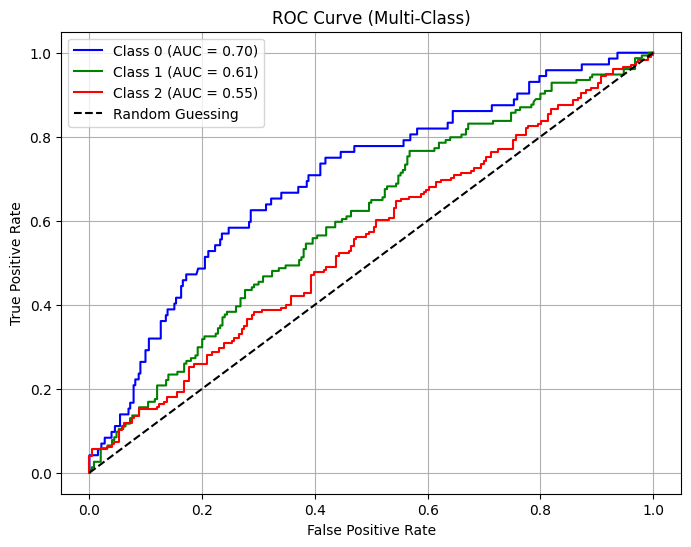

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class classification (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get probabilities for all classes
lr_proba = best_model_lr.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(8, 6))

# Colors for each class
colors = ['b', 'g', 'r']

# Plot ROC curve for each class
for i in range(3):
    # Compute ROC curve for class i (One-vs-Rest)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], lr_proba[:, i])

    # Compute ROC-AUC for class i
    auc_score = roc_auc_score(y_test_bin[:, i], lr_proba[:, i])

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot diagonal line for random guessing (i.e., AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-Class)')

# Show legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
